In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../behav/')
import plotting, utils, loading
data_path = '/mnt/cube/RawData/Zog/'

subjects = (
    'B1102',
    'B1073',
    'B1045',
    'B1044',
    'B1049',
)

In [2]:
import warnings

%load_ext autoreload
%autoreload 2

In [3]:
import datetime as dt

In [11]:
import seaborn as sns
sns.set_style("whitegrid")

## Loads Data

In [4]:
%%time
behav_data = loading.load_data_pandas(subjects,data_path)

/home/AD/tsainbur/.conda/envs/tim_python3/lib/python3.6/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)
../behav/loading.py:156: UserWarning: Warning: 1 Pandas dataframe contained non-datetime indexes
  warnings.warn('Warning: ' + str(len(broken_dfs))+' Pandas dataframe contained non-datetime indexes')


CPU times: user 31.7 s, sys: 1.18 s, total: 32.9 s
Wall time: 37.4 s


## plot performance over past two weeks in calendar

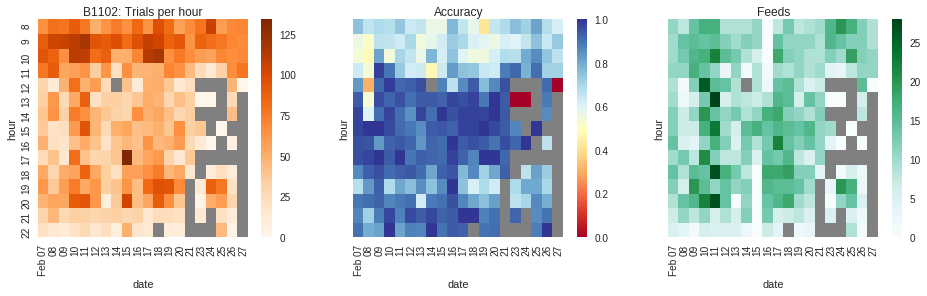

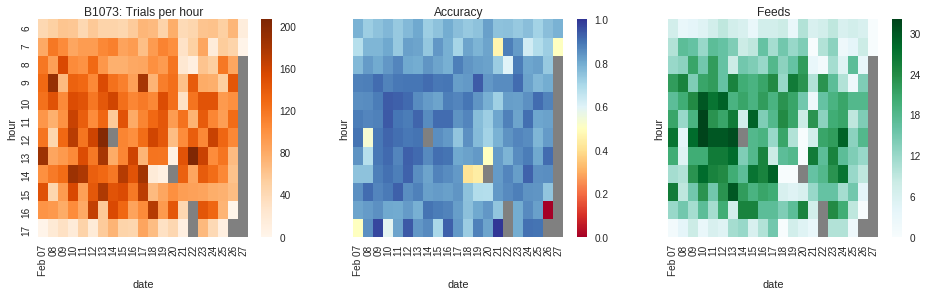

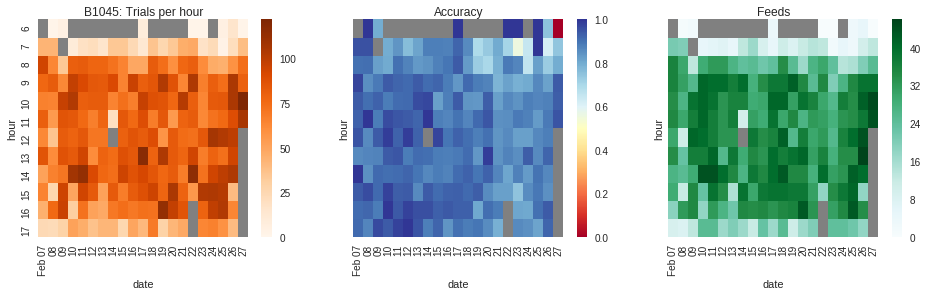

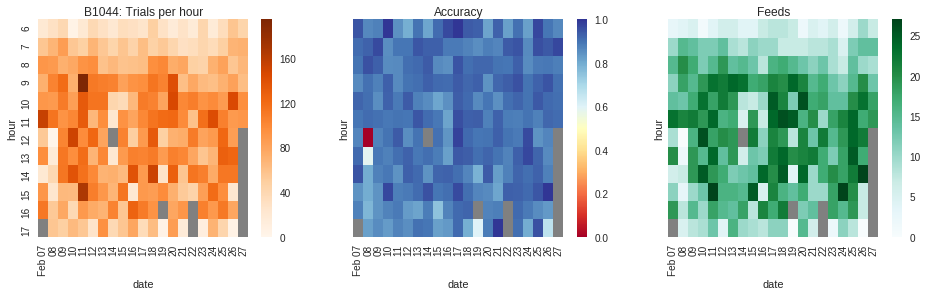

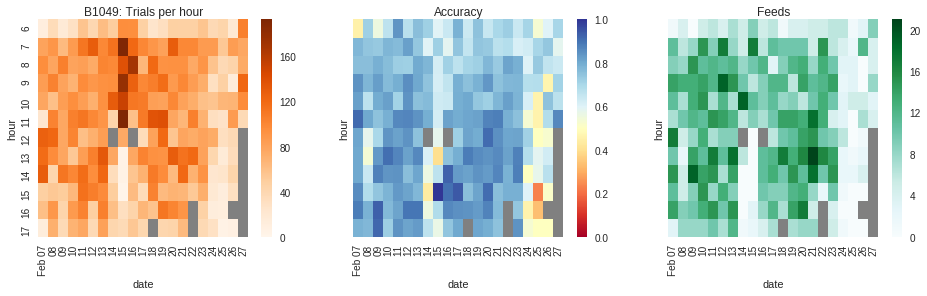

In [10]:
for subj,data in behav_data.items():
    plotting.plot_filtered_performance_calendar(subj,data,num_days=20)

## Plot percent correct by block with confidence bounds

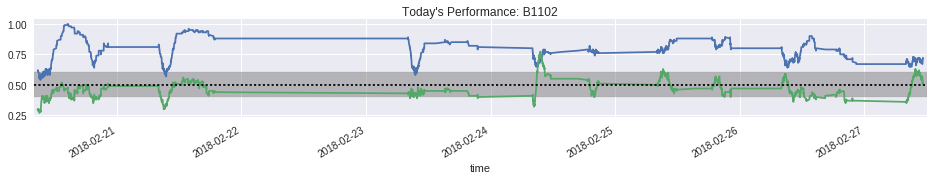

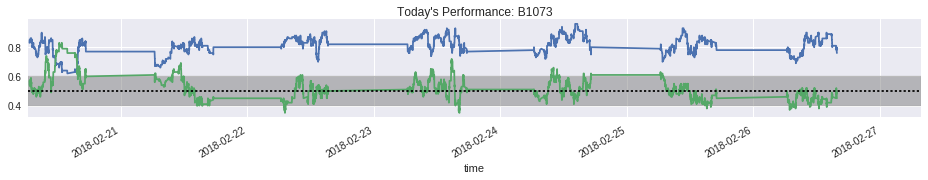

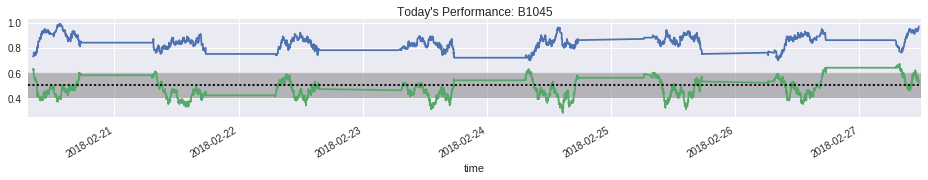

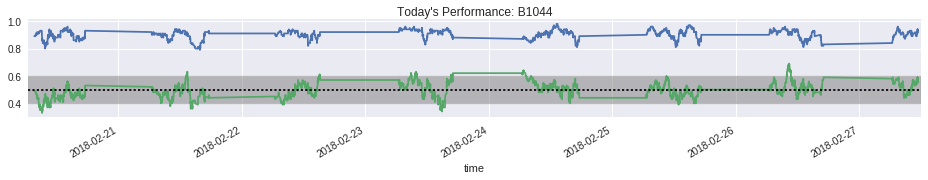

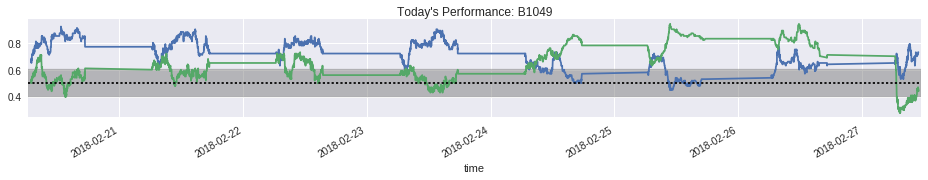

In [7]:
for subj,df in behav_data.items():
    plotting.plot_ci_accuracy(subj, df)

### plot accuracy today

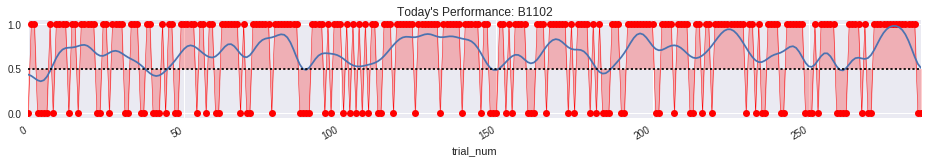

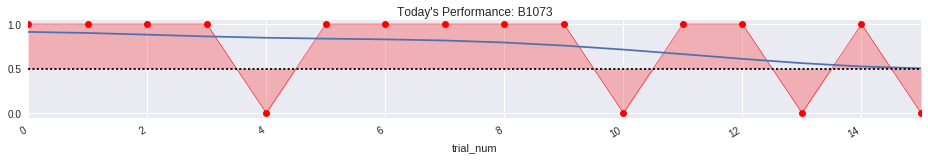

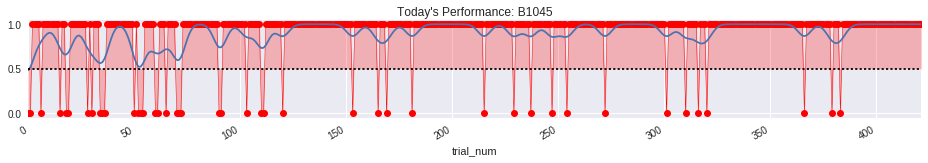

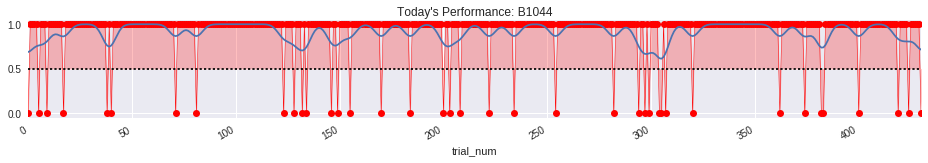

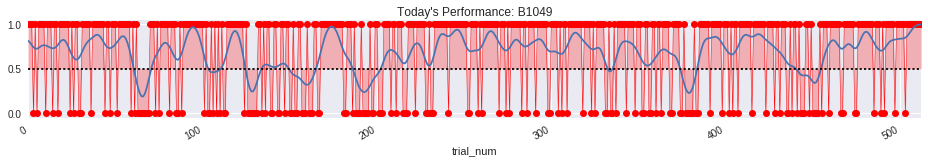

In [8]:
for subj,df in behav_data.items():
    plotting.plot_daily_accuracy(subj, df, x_axis='trial_num')

# Plot number of trials and feeds for past week

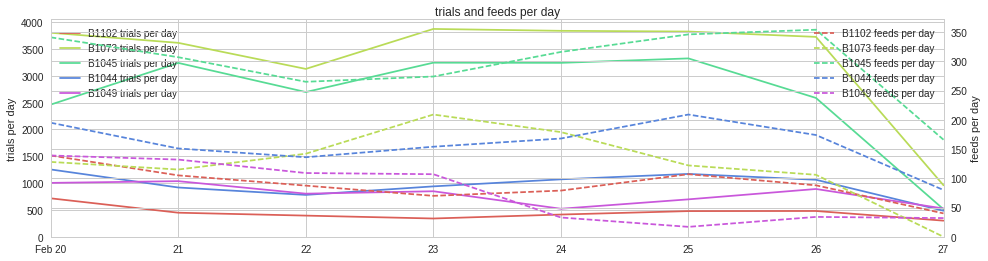

In [12]:
plotting.plot_trial_feeds(behav_data)